***
# Starting Kit - Black Swan HiggsML Course
***

In [1]:

# HiggsML utility package should not be modified
# %pip install HiggsML 
    

### Imports

In [2]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [3]:

root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

Root directory is d:\Work_Stuff\BlackSwan\Collaboration_A


## Import Submission Model
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements a basic model with 2 different model trained to predict the class label. 

* 1 XGBoost BDT ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/boosted_decision_tree.py) )
* 2 Tebsorflow NN  ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/neural_network.py) )

The feature engineering is in where you can include derived quantities and decide which feature should be needed. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/feature_engineering.py) ) 

the statistical analysis part is where yoiu write the mu finding calculation using the output of the classifier. ( [see](/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_code_submission/statistical_analysis.py) ) 

If running in Collab, click the folder icon in the left sidebar to open the file browser.


In [4]:
path.append(submission_dir)
from model import Model

## Data
### Available data sets
1. blackSwan_data
2. sample_data
3. neurips2024_data 

In [5]:
from HiggsML.datasets import download_dataset
data = download_dataset("blackSwan_data") # change to "blackswan_data" for the actual data

2025-05-20 14:45:52,502 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-05-20 14:45:52,502 - HiggsML.datasets     - INFO     - Current working directory: d:\Work_Stuff\BlackSwan\Collaboration_A
2025-05-20 14:45:52,502 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-05-20 14:45:52,508 - HiggsML.datasets     - INFO     - Test size: 600000


### ⚠️ Note:
The data used here is a small subset of the full data is for demonstration only to get a view of what the data looks like. 

In [6]:
# load train set
data.load_train_set(train_size=500_000)
data_set = data.get_train_set()

2025-05-20 14:45:52,634 - HiggsML.datasets     - INFO     - Selected train size: 500000
2025-05-20 14:45:53,210 - HiggsML.datasets     - INFO     - Data loaded successfully


***
# Visualize
***
- Visualize Train set

In [7]:
import HiggsML.visualization as visualization

train_visualize = visualization.Dataset_visualise(
    data_set=data_set,
    name="Train Set",
    columns=[
        "PRI_lep_phi",
        "PRI_met_phi",
        "PRI_had_phi",
        "PRI_jet_leading_phi",
        "PRI_jet_subleading_phi",
        "PRI_lep_pt",
        "PRI_met",
        "PRI_jet_leading_pt",
        "PRI_jet_subleading_pt",
    ]
)


General Structure of the data object is a dictionary
+------------------------+--------------------------+-------------------------------------+
| Key                    | Value                    | Type                                |
+========================+==========================+=====================================+
| PRI_lep_phi            | Array of shape (500000,) | <class 'pandas.core.series.Series'> |
+------------------------+--------------------------+-------------------------------------+
| PRI_met_phi            | Array of shape (500000,) | <class 'pandas.core.series.Series'> |
+------------------------+--------------------------+-------------------------------------+
| PRI_had_phi            | Array of shape (500000,) | <class 'pandas.core.series.Series'> |
+------------------------+--------------------------+-------------------------------------+
| PRI_jet_leading_phi    | Array of shape (500000,) | <class 'pandas.core.series.Series'> |
+------------------------+

In [8]:
# Show data summary
train_visualize.examine_dataset()


+--------------------+-----------+
| Key                | Value     |
+====================+===========+
| Dataset name       | Train Set |
+--------------------+-----------+
| Number of events   | 500000    |
+--------------------+-----------+
| Number of features | 9         |
+--------------------+-----------+ 

[*] --- Detailed Label Summary
+------------------+-----------------+--------------------+
| Detailed Label   |    Total Weight |   Number of events |
+==================+=================+====================+
| diboson          |  3769.95        |               1197 |
+------------------+-----------------+--------------------+
| htautau          |  1015.38        |             165520 |
+------------------+-----------------+--------------------+
| ttbar            | 44243.2         |              14089 |
+------------------+-----------------+--------------------+
| ztautau          |     1.0024e+06  |             319194 |
+------------------+-----------------+-------------

,PRI_lep_phi,PRI_met_phi,PRI_had_phi,PRI_jet_leading_phi,PRI_jet_subleading_phi,PRI_lep_pt,PRI_met,PRI_jet_leading_pt,PRI_jet_subleading_pt
0,-0.436,-0.300,2.524,-25.000,-25.000,20.622999,21.924000,-25.000000,-25.000000
1,1.487,2.646,2.681,-1.286,-0.066,39.840000,38.063000,73.082001,31.274000
2,2.283,1.962,-0.157,-25.000,-25.000,20.636000,27.358999,-25.000000,-25.000000
3,-0.247,-0.780,1.332,3.038,-2.534,31.129999,26.608000,81.306999,26.778999
4,-2.107,-2.701,0.868,-25.000,-25.000,26.084000,7.335000,-25.000000,-25.000000



[*] --- Description of all features



,PRI_lep_phi,PRI_met_phi,PRI_had_phi,PRI_jet_leading_phi,PRI_jet_subleading_phi,PRI_lep_pt,PRI_met,PRI_jet_leading_pt,PRI_jet_subleading_pt
count,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,-0.00252,0.000689,0.002859,-13.136152,-19.410606,33.978447,25.008276,20.461168,-8.424611
std,1.81363,1.813972,1.812232,12.545676,10.453903,18.149134,28.078899,63.193451,34.295406
min,-3.14200,-3.142000,-3.142000,-25.000000,-25.000000,20.000000,0.016000,-25.000000,-25.000000
25%,-1.57100,-1.570000,-1.560000,-25.000000,-25.000000,23.959999,9.732750,-25.000000,-25.000000
50%,-0.00400,-0.002000,0.010000,-25.000000,-25.000000,29.019500,16.879000,-25.000000,-25.000000
75%,1.57000,1.575000,1.572000,-0.178000,-25.000000,37.167000,28.970250,47.071999,-25.000000
max,3.14200,3.142000,3.142000,3.142000,3.142000,749.392029,772.572021,1108.150024,698.346008


[*] --- PRI_lep_phi histogram
[*] --- PRI_met_phi histogram
[*] --- PRI_had_phi histogram
[*] --- PRI_jet_leading_phi histogram
[*] --- PRI_jet_subleading_phi histogram
[*] --- PRI_lep_pt histogram
[*] --- PRI_met histogram
[*] --- PRI_jet_leading_pt histogram
[*] --- PRI_jet_subleading_pt histogram


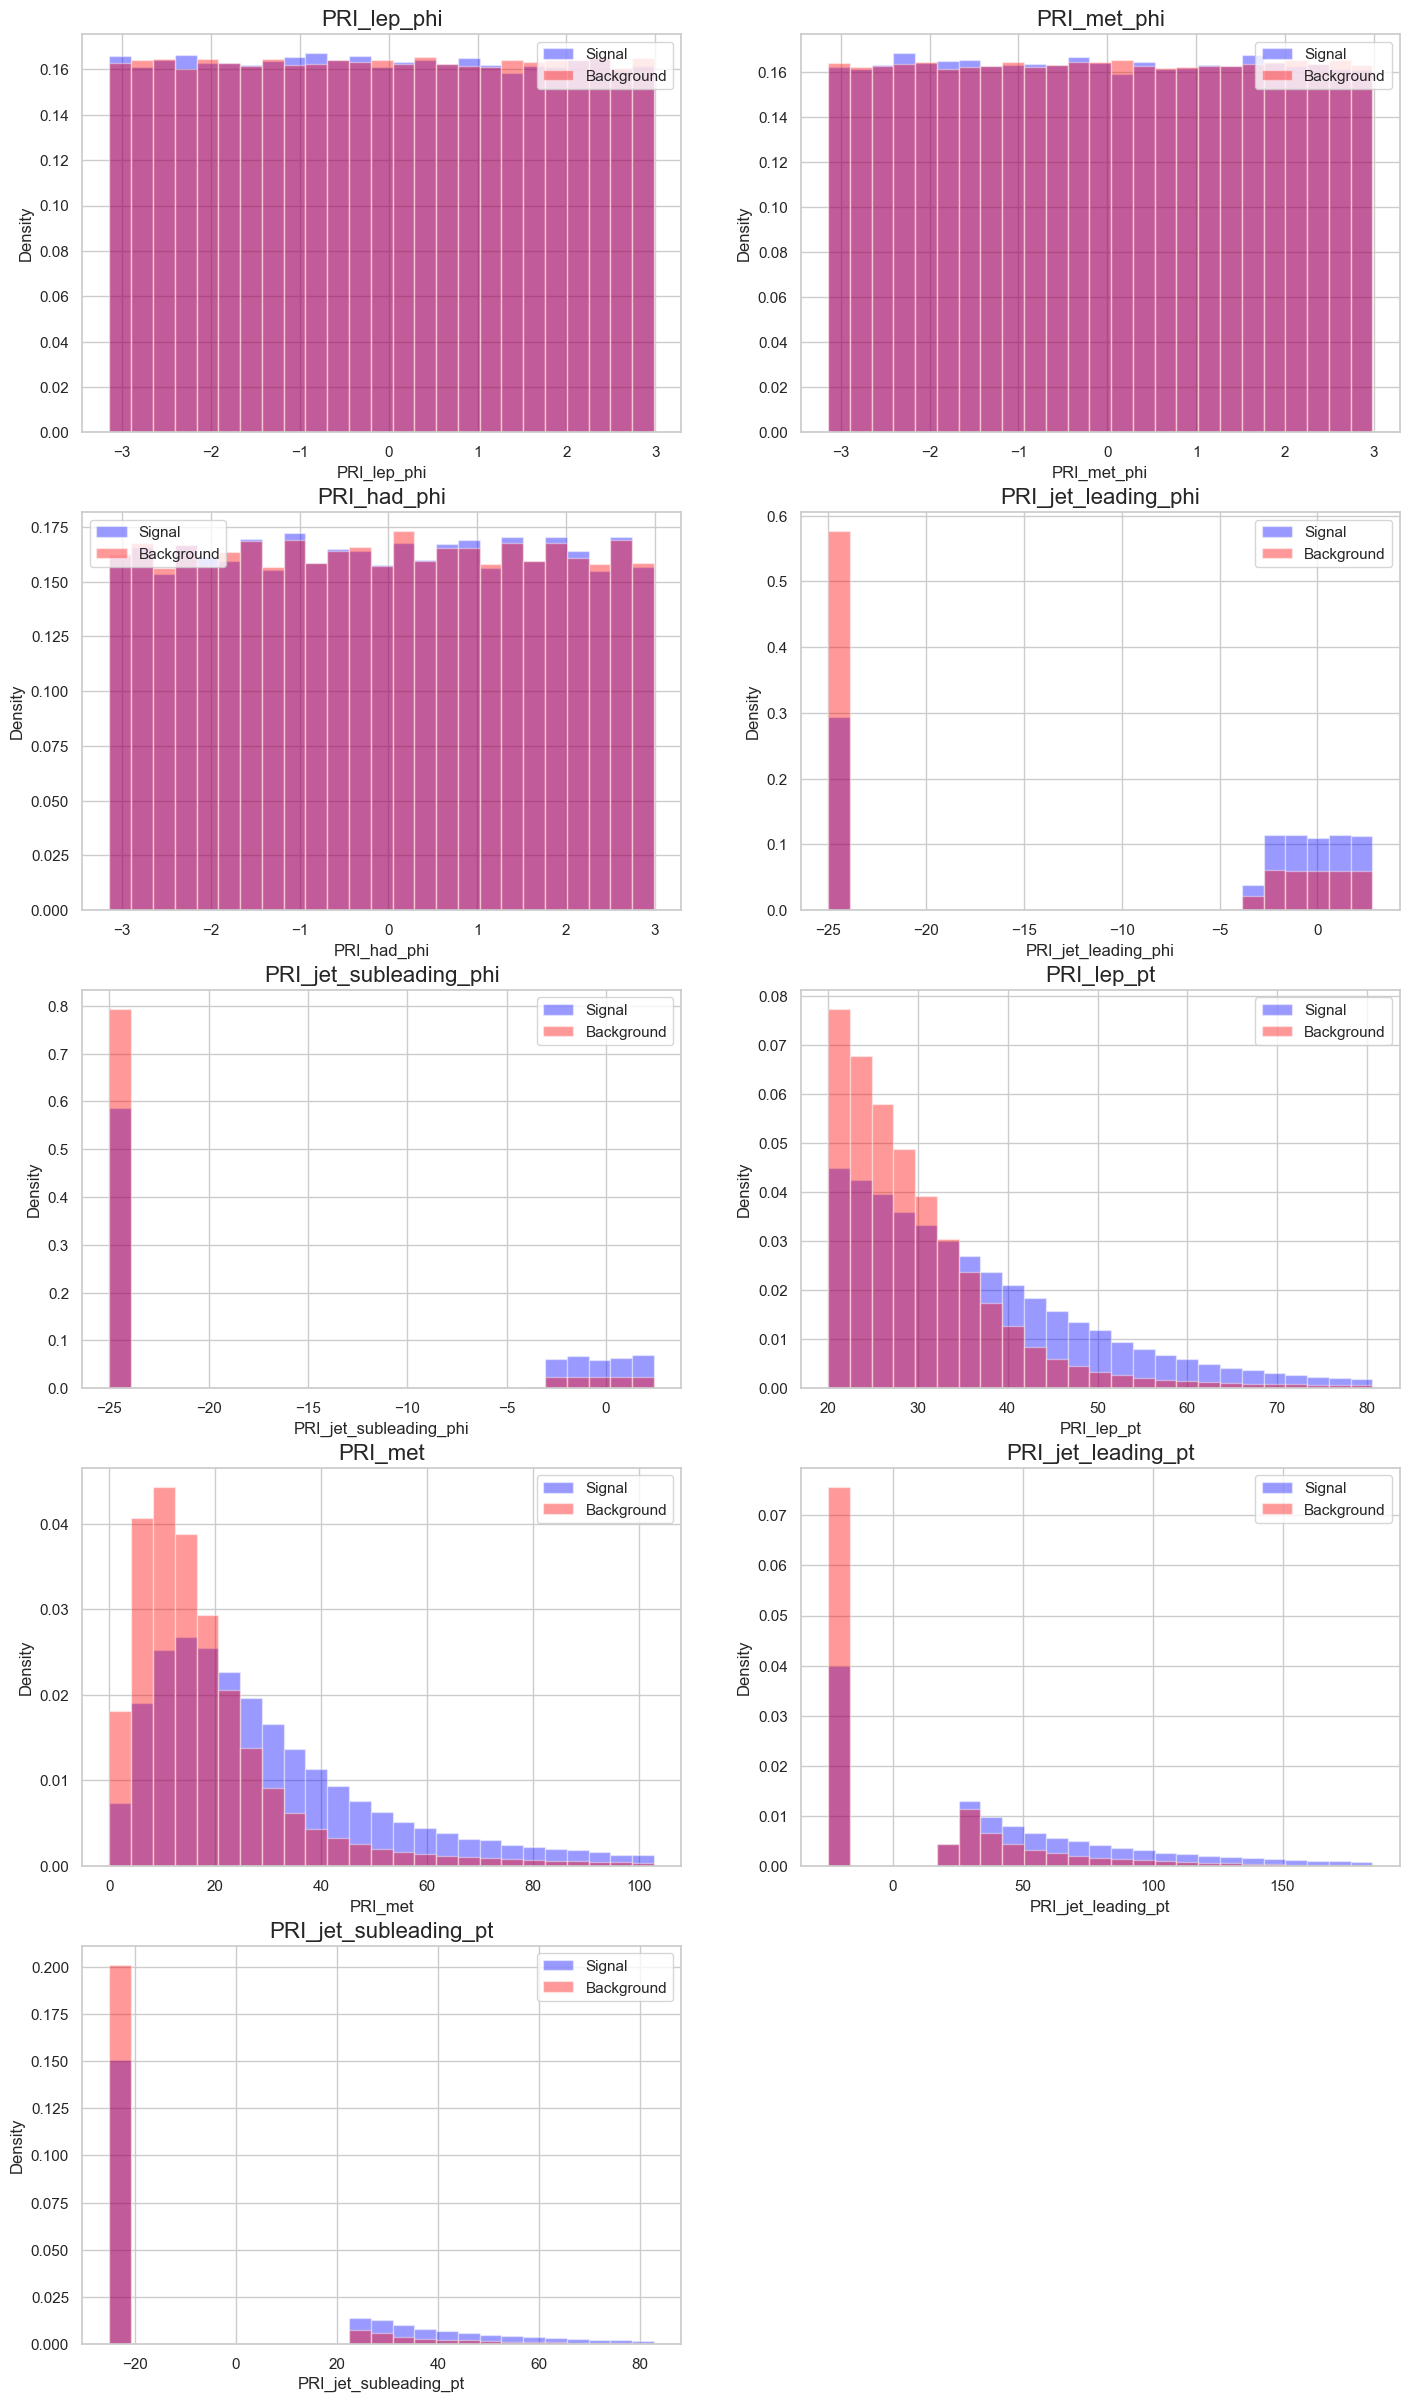

In [9]:
# Show data summary

train_visualize.histogram_dataset()

Signal feature  correlation matrix


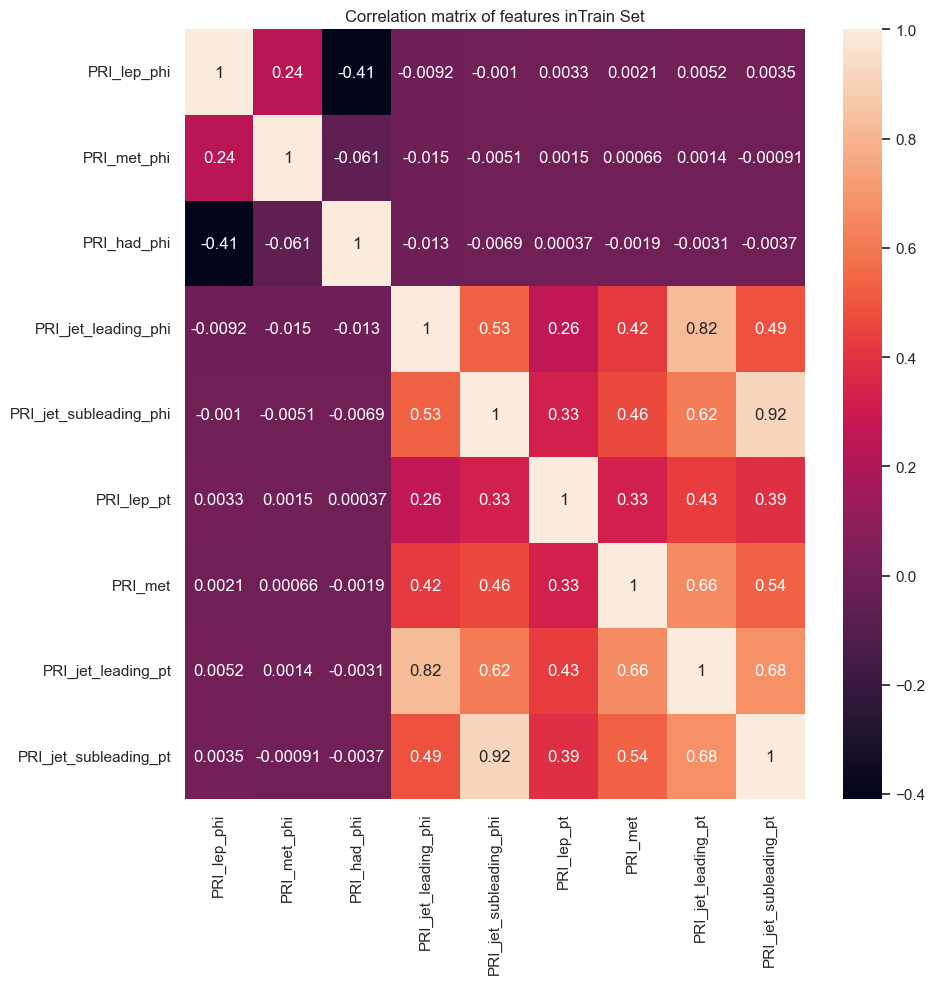

Background feature  correlation matrix


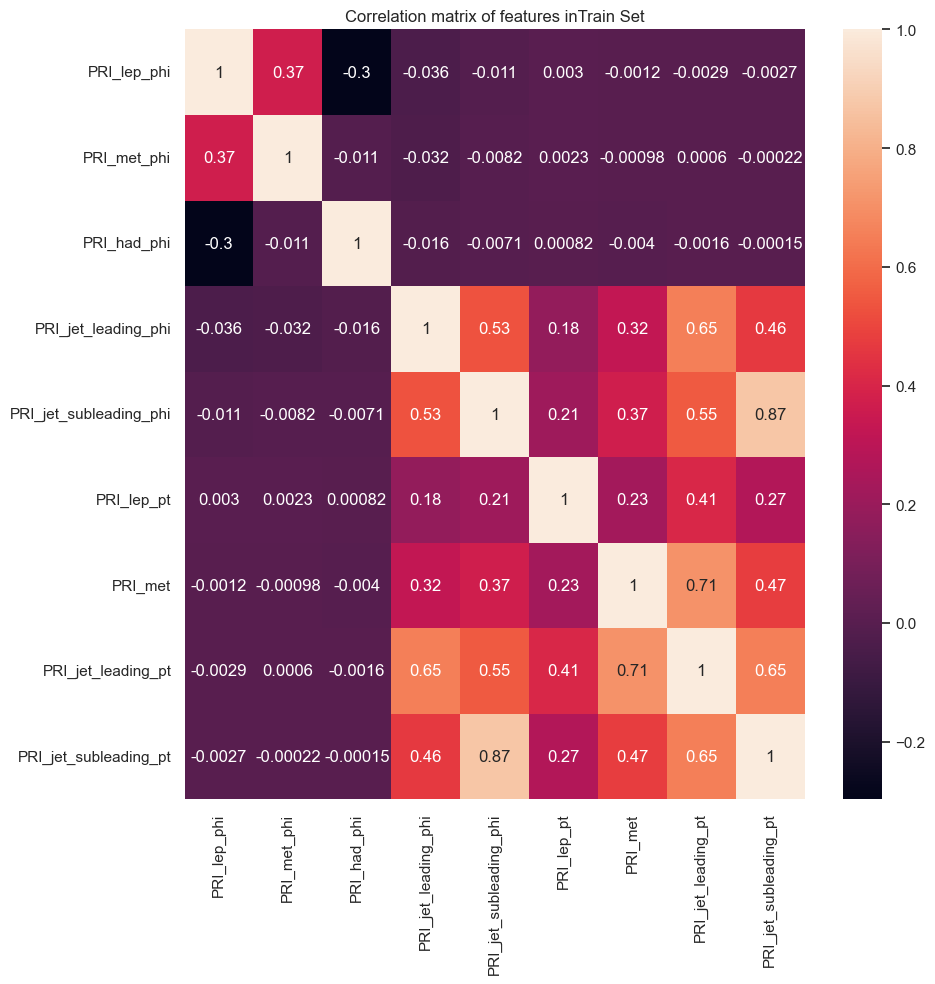

In [10]:
train_visualize.correlation_plots()

diboson (1197,)
diboson (1197,)
htautau (30,)
ttbar (14089,)
ttbar (14089,)
ztautau (319194,)
ztautau (319194,)


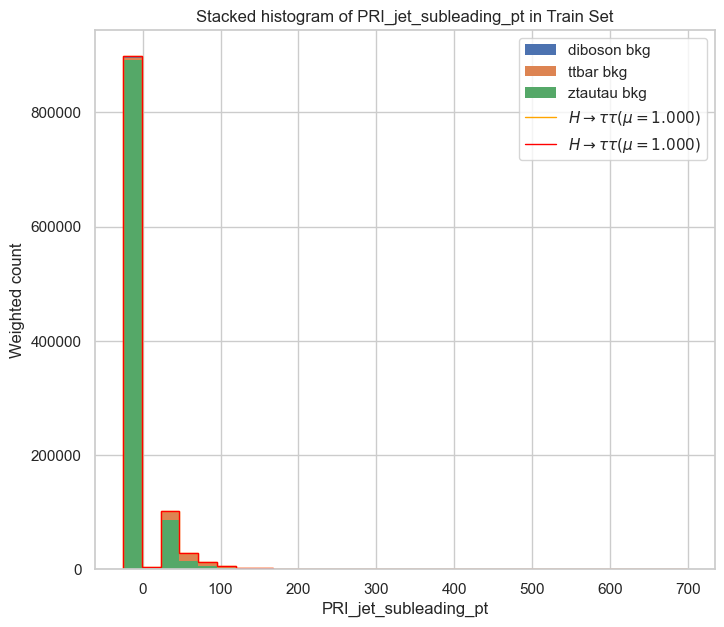

In [11]:
train_visualize.stacked_histogram("PRI_jet_subleading_pt")

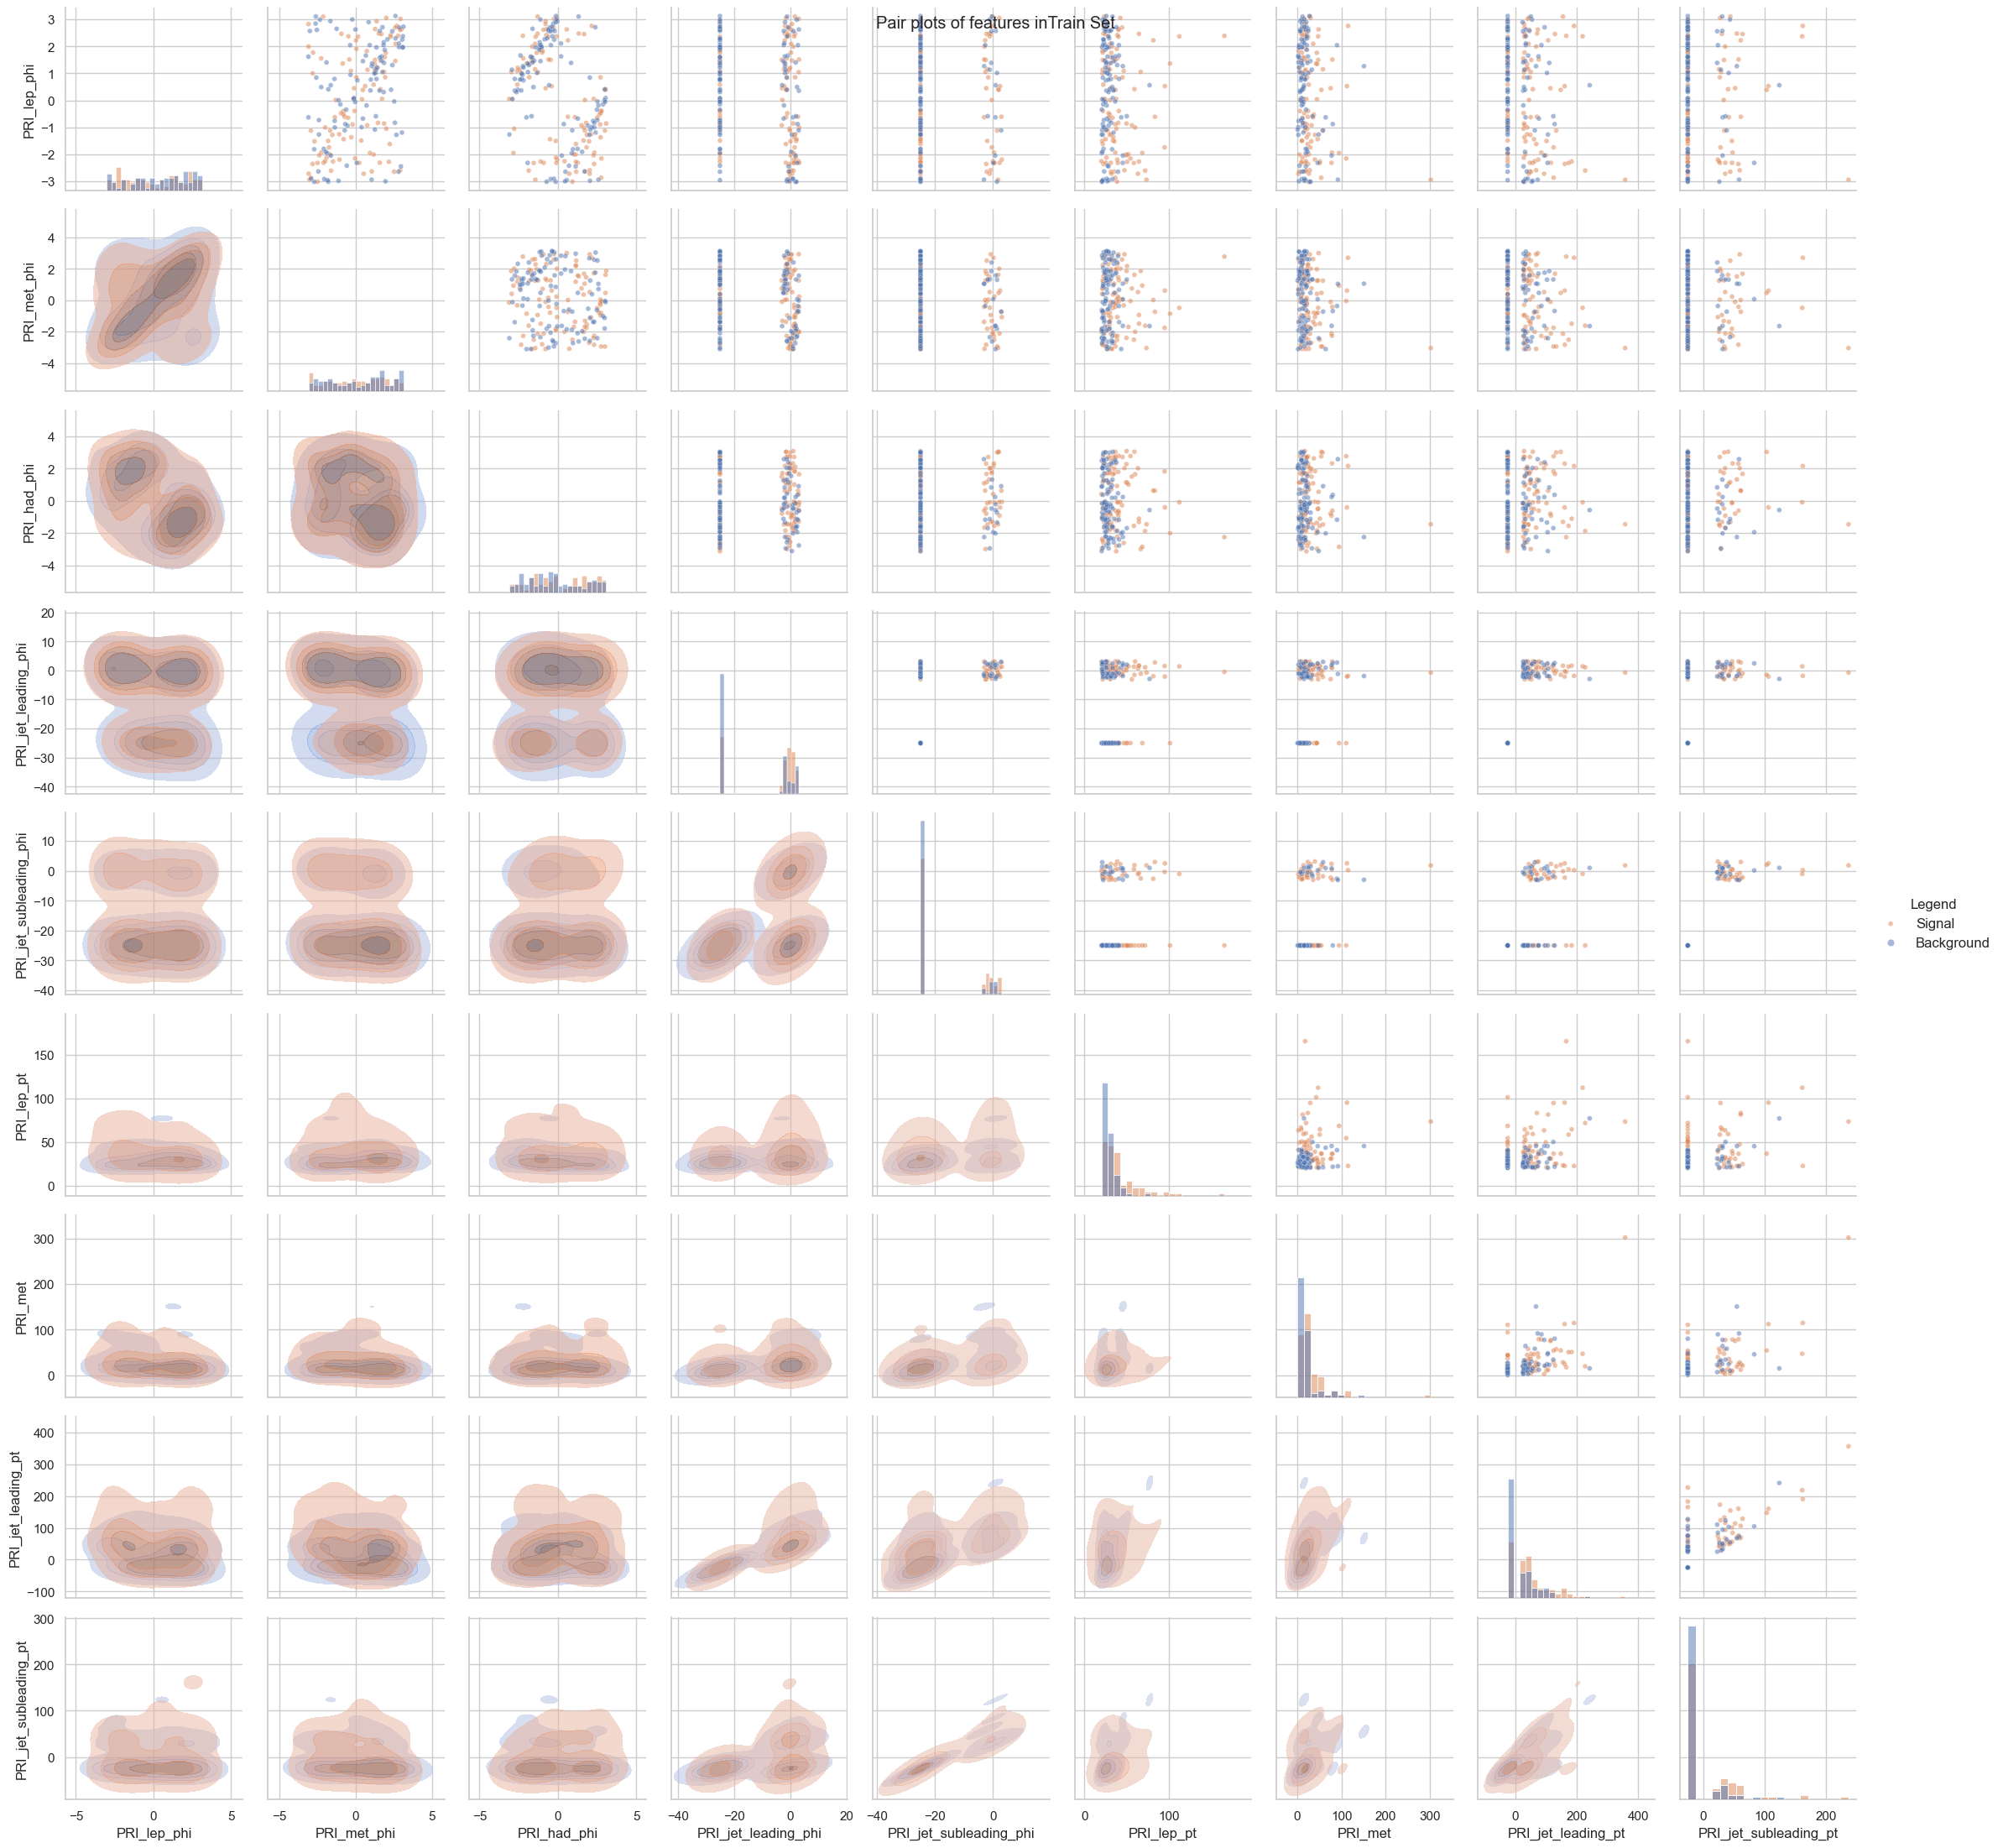

In [12]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

### Test Settings
The Test setting sets the test conditions in ingestion.
This includes what systematics you want and how many psuedo experiments you want. 

In [13]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 10,  # Number of pseudo-experiments to run per set
    "num_of_sets": 2,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42

In [14]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)


### Ingestion



In [15]:

from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)


In [16]:

# initialize submission
ingestion.init_submission(Model)

2025-05-20 14:46:30,607 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-05-20 14:46:30,608 - HiggsML.datasets     - INFO     - Selected train size: 50
2025-05-20 14:46:31,108 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-20 14:46:31,125 - HiggsML.datasets     - INFO     - Selected train size: 50


Training Data:  (50, 28)
Training Labels:  (50,)
Training Weights:  (50,)
sum_signal_weights:  1154.6694337732804
sum_bkg_weights:  1050278.3305662265


2025-05-20 14:46:31,558 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-20 14:46:31,574 - HiggsML.datasets     - INFO     - Selected train size: 50



Valid Data:  (50, 28)
Valid Labels:  (50,)
Valid Weights:  (50,)
sum_signal_weights:  1257.0890226030656
sum_bkg_weights:  1050175.9109773973


2025-05-20 14:46:32,169 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (50, 28)
Holdout Labels:  (50,)
Holdout Weights:  (50,)
sum_signal_weights:  1368.818671318268
sum_bkg_weights:  1050064.1813286815
 
 
Training Data:  (50, 28)
 Model is Sample Model


2025-05-20 14:46:32,222 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


score shape before threshold (50,)
score shape after threshold (50,)
saved_info {'beta': 840059.2035578887, 'gamma': 1163.6278475769705, 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x00000207C5D16D30>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x00000207C5D16160>}
Train Results: 
	 mu_hat  :  12.340242205009748
	 del_mu_stat  :  0.7882090545656629
	 del_mu_sys  :  1.2340242205009748
	 del_mu_tot  :  1.4642709074765963
Holdout Results: 
	 mu_hat  :  1.0000000000000078
	 del_mu_stat  :  0.7882090545656629
	 del_mu_sys  :  0.10000000000000078
	 del_mu_tot  :  0.7945272265311594
Valid Results: 
	 mu_hat  :  94.20160745063869
	 del_mu_stat  :  0.7882090545656629
	 del_mu_sys  :  9.42016074506387
	 del_mu_tot  :  9.453078968068635

General Structure of the data object is a dictionary
+--------------------+----------------------+-------------------------------------+
| Key                | Value                | Type                                |
+==============

,PRI_jet_leading_pt,PRI_met,score
0,134.770996,54.230,92.854210
1,-25.000000,21.924,119.203331
2,73.082001,38.063,121.299896
3,-25.000000,8.964,56.355362
4,-25.000000,18.826,48.339912



[*] --- Description of all features



,PRI_jet_leading_pt,PRI_met,score
count,50.000000,50.000000,50.000000
mean,15.134779,25.291861,203.837387
std,56.332550,27.762327,520.837585
min,-25.000000,1.691000,-25.000000
25%,-25.000000,11.252000,50.822162
50%,-25.000000,18.813000,80.566299
75%,44.623500,28.794000,124.092941
max,192.470993,175.263000,3094.935303


[*] --- PRI_jet_leading_pt histogram
[*] --- PRI_met histogram
[*] --- score histogram
htautau (30,)
ttbar (1,)
ttbar (1,)
ztautau (30,)
ztautau (30,)


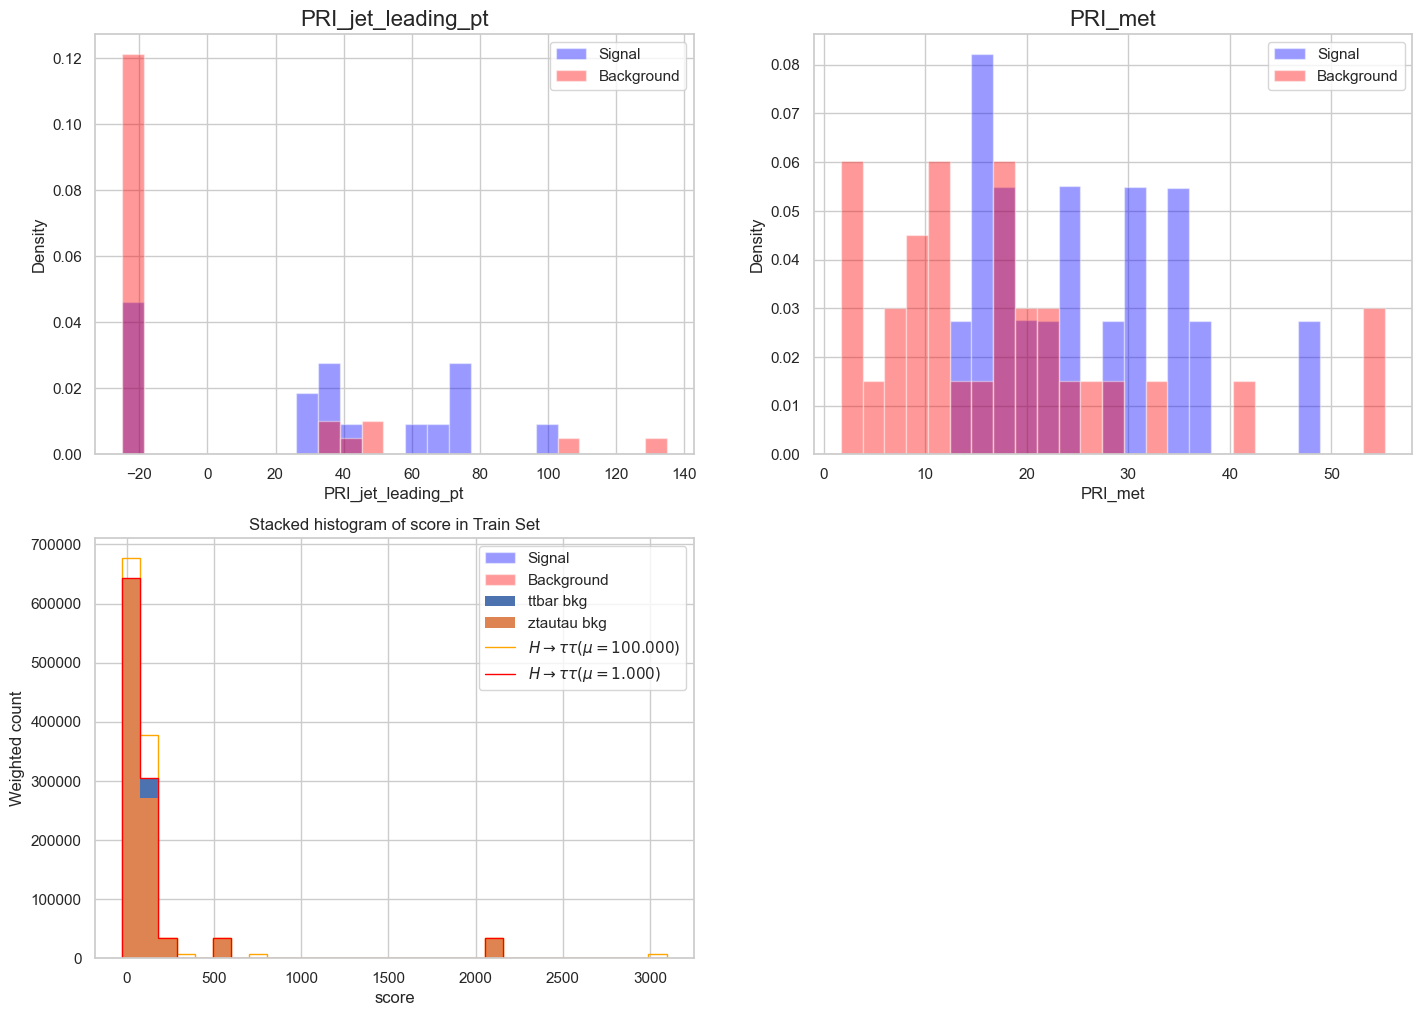

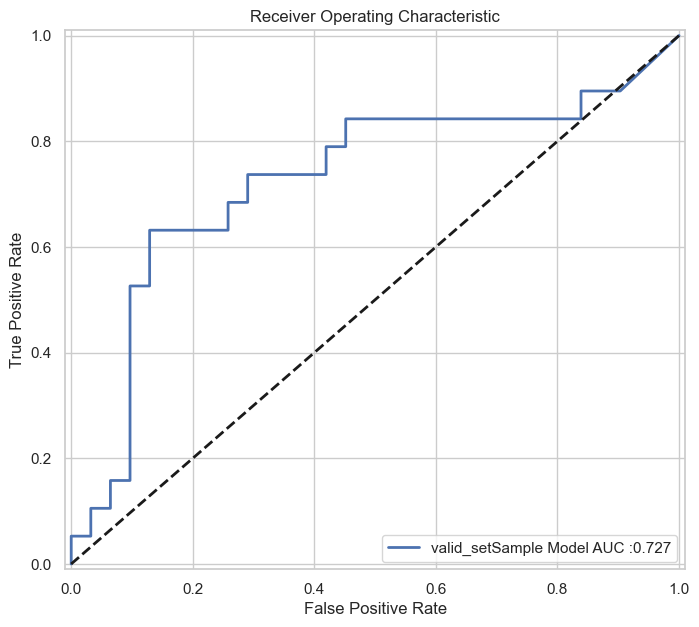

In [17]:

# fit submission
ingestion.fit_submission()

In [18]:

# load test set
data.load_test_set()

2025-05-20 14:46:35,209 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-05-20 14:46:35,660 - HiggsML.datasets     - INFO     - Test data loaded successfully


In [19]:

# predict submission
ingestion.predict_submission(test_settings)

2025-05-20 14:46:35,696 - HiggsML.ingestion    - INFO     - Calling predict method of submitted model with seed: 31415


Test Results:  {'mu_hat': -90.55661892013852, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.055661892013852, 'del_mu_tot': 9.089900209362652}
Test Results:  {'mu_hat': -92.79444779766352, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.279444779766353, 'del_mu_tot': 9.312860405612891}
Test Results:  {'mu_hat': -93.13218464438675, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.313218464438675, 'del_mu_tot': 9.346513343491292}
Test Results:  {'mu_hat': -92.37850725360741, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.237850725360742, 'del_mu_tot': 9.271416263858898}
Test Results:  {'mu_hat': -90.37185194292351, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.037185194292352, 'del_mu_tot': 9.071493248062096}
Test Results:  {'mu_hat': -90.50247789890808, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.05024778989081, 'del_mu_tot': 9.084506512305595}
Test Results:  {'mu_hat': -91.37818743277826, 'del_mu_stat': 0.7882090545656629, 'del_mu_sys': 9.137818743277826, 'del_

In [20]:
ingestion.process_results_dict()

In [21]:

# save result
ingestion.save_result(output_dir)


## Score
1. Compute Scores
2. Visualize Scores


In [22]:
from HiggsML.score import Scoring

In [23]:
# Initialize Score
score = Scoring()

In [24]:
print(output_dir)
score.load_ingestion_results(prediction_dir = output_dir, score_dir = output_dir)

2025-05-20 14:47:07,980 - HiggsML.score        - INFO     - Read ingestion results from d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


d:\Work_Stuff\BlackSwan\Collaboration_A\sample_result_submission


2025-05-20 14:47:08,003 - HiggsML.score        - INFO     - Computing scores


[✔]


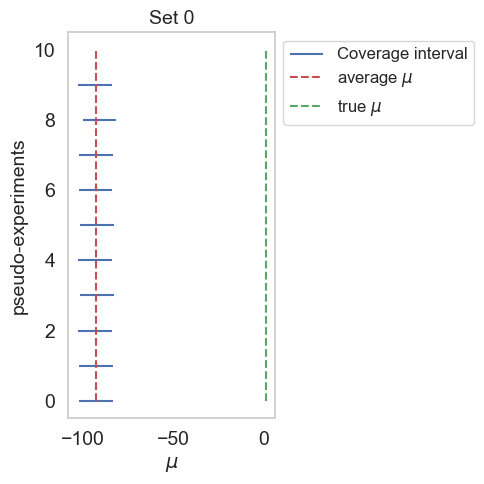

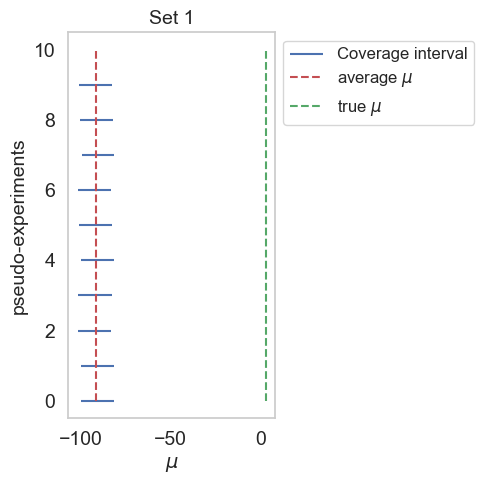

In [25]:
# Compute Score
score.compute_scores(test_settings)


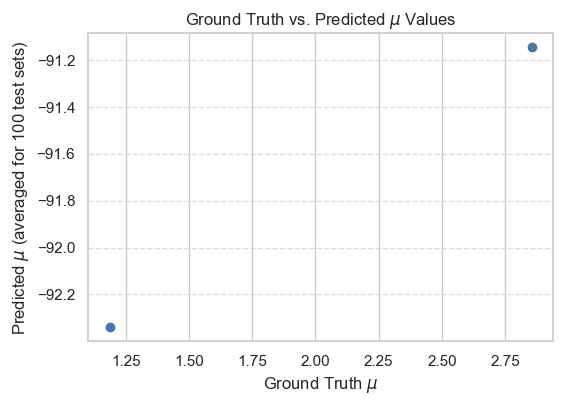

In [26]:
# Visualize scatter plot of ground truth mu and predicted mu
visualization.visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

## Submissions

In [27]:
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing
# -------------------------------------
# Zip files
# -------------------------------------
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

### **Prepare the submission**

In [28]:
import datetime
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'BlackSwan-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")


Submit : BlackSwan-code_submission_25-05-20-14-47.zip to the competition


In [29]:
!python3 -m HiggsML.score --prediction $output_dir --output $output_dir

'python3' is not recognized as an internal or external command,
operable program or batch file.
